# NBA Player Performance and Positions

## CMSC320 Fall 2025 Data Science Final Project

### Group Members
- Anitej Suklikar
- Joshua John
- Sachin Kumar
- Akhil Metukuru
- Purab Shah
- Sohum Desai

### Contributions
- **A: Project Idea** – all members
- **B: Dataset Curation & Preprocessing** – Anitej, Joshua
- **C: Data Exploration & Summary Statistics** – Akhil, Sohum
- **D: ML Algorithm Design/Development** – Sachin, Purab
- **E: ML Algorithm Training and Test Data Analysis** – Sachin, Joshua
- **F: Visualization, Result Analysis, Conclusion** – Sohum, Akhil
- **G: Final Tutorial Report Creation** – all members

---


## 1. Introduction

Basketball analytics has transformed how teams, coaches, and fans understand player roles. In this project, we analyze an NBA game-level dataset to understand how a player's box-score statistics relate to their on-court position.

We focus on the following questions:

1. **Can we predict a player's starting position (Guard, Forward, or Center) from a single game's statistics?**
2. **Which statistics are most important for distinguishing between positions?**

To answer these questions, we follow the full data science pipeline:
- **Data Curation**: Loading and cleaning raw NBA game data
- **Exploratory Analysis**: Understanding distributions, relationships, and statistical significance
- **Supervised Learning**: Training Logistic Regression and Random Forest classifiers
- **Visualization & Interpretation**: Confusion matrices and feature importance analysis

This tutorial demonstrates a complete, reproducible data science workflow from raw data to actionable insights.


## 2. Data Curation

We use the `player_data.csv` dataset, which contains over **250,000 NBA player-game records** with **115 columns** of box-score and advanced statistics. The data comes from the [NBA Player Statistics dataset on Kaggle](https://www.kaggle.com/datasets/marcsperzel/nba-player-statistics).

Our data curation process includes:
- Loading the CSV into pandas
- Removing rows with missing key values
- Keeping only players who have a recorded starting position (`START_POSITION` = G/F/C)
- Converting data types and handling missing values

Below we show basic information about the dataset and the columns we use.


In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Set visualization style
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the dataset
csv_path = "player_data.csv"
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head()


Dataset shape: 255,914 rows × 115 columns


,_id,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,...,E_PACE,AST_RATIO,DIST,AST_TOV,FTA_RATE,OPP_FTA_RATE,MIN,PACE_PER40,PACE,PIE
0,6257e8a35ccc080408fc781f,21500395,2015-12-18,1610612762,UTA,Utah,202353,Tibor Pleiss,Tibor,NaN,...,0.00,0.0,0.00,0.0,0.000,0.000,0.00,0.00,0.00,0.000
1,6257e8a35ccc080408fc7814,21500395,2015-12-18,1610612762,UTA,Utah,1626168,Trey Lyles,Trey,F,...,87.14,12.5,1.76,1.0,0.333,0.372,26.06,72.03,86.44,0.094
2,6257e8a35ccc080408fc7815,21500395,2015-12-18,1610612762,UTA,Utah,202324,Derrick Favors,Derrick,C,...,86.71,0.0,2.39,0.0,0.291,0.267,35.27,71.65,85.98,0.020
3,6257e8a35ccc080408fc7807,21500395,2015-12-18,1610612743,DEN,Denver,201568,Danilo Gallinari,Danilo,F,...,90.37,14.3,2.22,0.0,0.233,0.377,33.43,75.93,91.11,0.050
4,6257e8a35ccc080408fc7810,21500395,2015-12-18,1610612743,DEN,Denver,203123,Kostas Papanikolaou,Kostas,NaN,...,96.36,0.0,0.87,0.0,0.733,0.294,11.28,78.49,94.19,0.000


In [3]:
# Examine dataset structure
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255914 entries, 0 to 255913
Columns: 115 entries, _id to PIE
dtypes: float64(65), int64(43), object(7)
memory usage: 224.5+ MB


In [4]:
# Check the distribution of START_POSITION
pos_col = "START_POSITION"
print("Distribution of START_POSITION:")
print(df[pos_col].value_counts(dropna=False))


Distribution of START_POSITION:
START_POSITION
NaN    157651
F       39306
G       39305
C       19652
Name: count, dtype: int64


In [5]:
# Create cleaned dataset for EDA
key_columns = [
    'GAME_DATE', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_NAME', 'START_POSITION',
    'MIN', 'PTS', 'REB', 'AST', 'TO', 'STL', 'BLK', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PIE'
]

# Filter to columns that exist in the dataframe
available_cols = [col for col in key_columns if col in df.columns]
nba_clean = df[available_cols].copy()

# Fill missing positions with 'Bench' for EDA purposes
nba_clean['START_POSITION'] = nba_clean['START_POSITION'].fillna('Bench')

# Drop rows with missing numeric values
nba_clean = nba_clean.dropna(subset=['PTS', 'REB', 'AST'])

print(f"Cleaned dataset: {len(nba_clean):,} rows")
nba_clean.head()


Cleaned dataset: 255,914 rows


,GAME_DATE,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_NAME,START_POSITION,MIN,PTS,REB,AST,TO,STL,BLK,FG_PCT,FG3_PCT,FT_PCT,PIE
0,2015-12-18,UTA,Utah,Tibor Pleiss,Bench,0.00,0,0,0,0,0,0,0.000,0.00,0.0,0.000
1,2015-12-18,UTA,Utah,Trey Lyles,F,26.06,6,6,1,1,0,0,0.500,0.00,0.0,0.094
2,2015-12-18,UTA,Utah,Derrick Favors,C,35.27,7,9,0,1,1,0,0.250,0.00,0.6,0.020
3,2015-12-18,DEN,Denver,Danilo Gallinari,F,33.43,11,1,2,0,0,0,0.299,0.25,1.0,0.050
4,2015-12-18,DEN,Denver,Kostas Papanikolaou,Bench,11.28,1,2,0,2,1,0,0.000,0.00,0.5,0.000


## 3. Exploratory Data Analysis

In this section we summarize the main properties of the dataset and explore relationships between key variables. We focus on:

- **Distributions** of scoring, assists, and rebounding
- **Relationships** between playmaking (assists) and turnovers
- **Statistical testing** to examine the relationship between playing time and player impact

### 3.1 Descriptive Statistics and Distribution Analysis

We begin by exploring the overall distribution of player performance metrics. We calculate summary statistics for **Points (PTS)**, **Assists (AST)**, and **Rebounds (REB)** to understand the central tendency and spread of the data.


In [6]:
# Summary statistics
print("Summary Statistics for Key Performance Metrics:\n")
print(nba_clean[['PTS', 'AST', 'REB']].describe())


Summary Statistics for Key Performance Metrics:

                PTS            AST            REB
count  255914.00000  255914.000000  255914.000000
mean        8.05106       1.759958       3.348414
std         8.21757       2.390910       3.508625
min         0.00000       0.000000       0.000000
25%         0.00000       0.000000       0.000000
50%         6.00000       1.000000       2.000000
75%        13.00000       3.000000       5.000000
max        70.00000      24.000000      30.000000


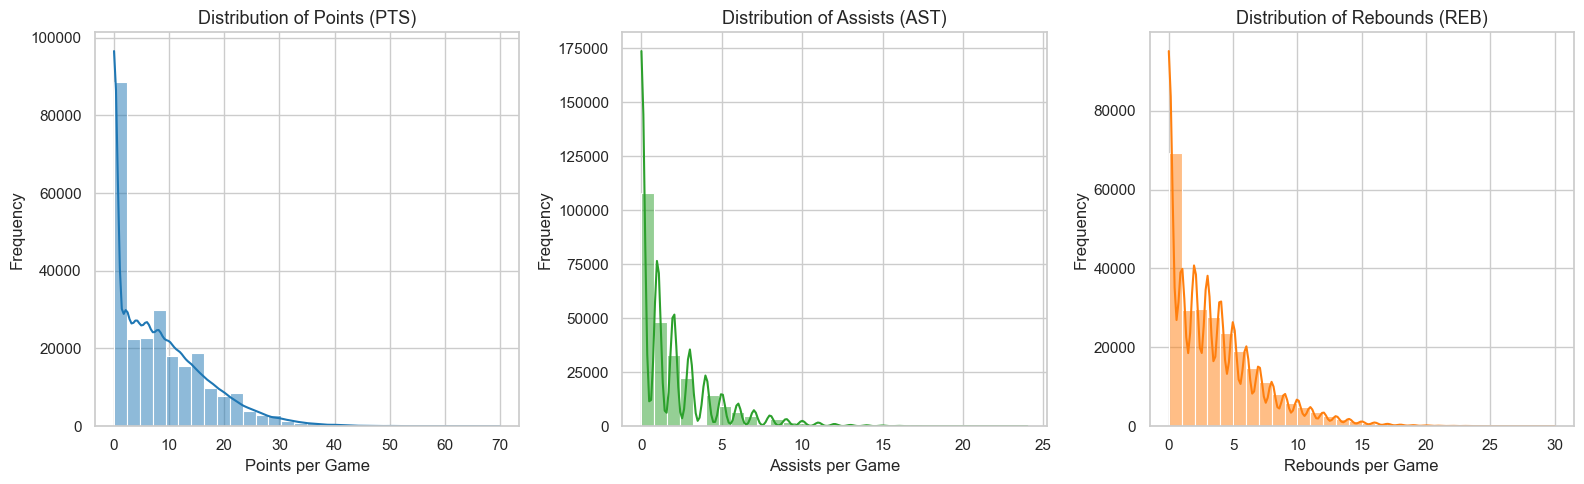

In [7]:
# Visualize distributions with histograms
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['#1f77b4', '#2ca02c', '#ff7f0e']

sns.histplot(nba_clean['PTS'], bins=30, kde=True, color=colors[0], ax=axes[0])
axes[0].set_title('Distribution of Points (PTS)', fontsize=13)
axes[0].set_xlabel('Points per Game')
axes[0].set_ylabel('Frequency')

sns.histplot(nba_clean['AST'], bins=30, kde=True, color=colors[1], ax=axes[1])
axes[1].set_title('Distribution of Assists (AST)', fontsize=13)
axes[1].set_xlabel('Assists per Game')
axes[1].set_ylabel('Frequency')

sns.histplot(nba_clean['REB'], bins=30, kde=True, color=colors[2], ax=axes[2])
axes[2].set_title('Distribution of Rebounds (REB)', fontsize=13)
axes[2].set_xlabel('Rebounds per Game')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('distribution_histograms.png', dpi=150, bbox_inches='tight')
plt.show()


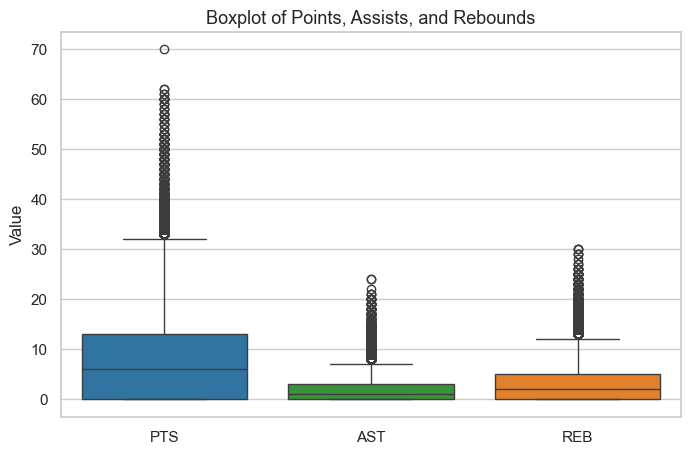

In [8]:
# Boxplots for comparison
plt.figure(figsize=(8, 5))
sns.boxplot(data=nba_clean[['PTS', 'AST', 'REB']], palette=colors)
plt.title('Boxplot of Points, Assists, and Rebounds', fontsize=13)
plt.ylabel('Value')
plt.savefig('boxplots.png', dpi=150, bbox_inches='tight')
plt.show()


**Conclusion:** All three metrics are heavily right-skewed. Most players record low values per game, while a few players contribute exceptional performances. Points (PTS) show the widest spread and most outliers, indicating that scoring is the most variable statistic across players.

### 3.2 Relationship Analysis: Assists vs Turnovers

This section examines the trade-off between playmaking and decision-making risk among players. We analyze the relationship between Assists (AST) and Turnovers (TO) to understand how ball-handling activity influences performance outcomes.


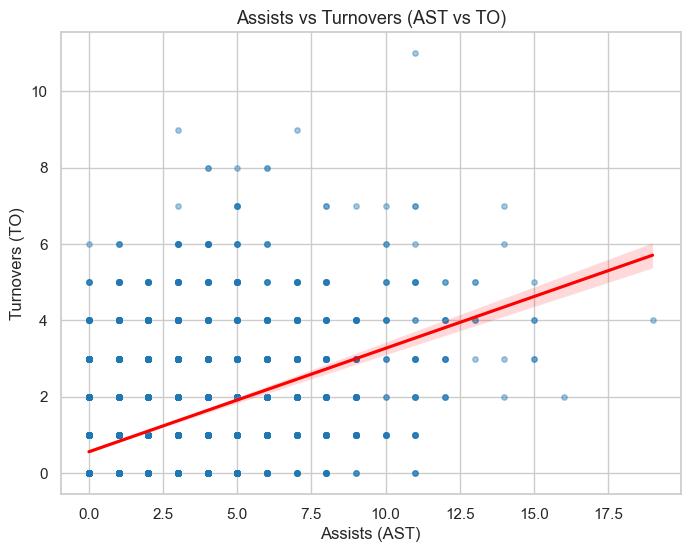

In [9]:
# Sample data for scatter plot (for performance)
if 'TO' in nba_clean.columns:
    ast_to_sample = nba_clean.dropna(subset=['AST', 'TO']).sample(5000, random_state=42)
    
    plt.figure(figsize=(8, 6))
    sns.regplot(
        x='AST', y='TO', data=ast_to_sample,
        scatter_kws={'alpha': 0.4, 's': 15, 'color': '#1f77b4'},
        line_kws={'color': 'red'}
    )
    plt.title('Assists vs Turnovers (AST vs TO)', fontsize=13)
    plt.xlabel('Assists (AST)')
    plt.ylabel('Turnovers (TO)')
    plt.savefig('ast_vs_to.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("TO column not available for this analysis")


**Conclusion:** The scatter plot reveals a strong positive relationship between assists (AST) and turnovers (TO). Players who record more assists also tend to commit more turnovers, reflecting the inherent trade-off between playmaking and risk.

### 3.3 Hypothesis Testing: Minutes vs Player Impact

We examine whether players who play more minutes per game tend to have a higher overall impact, measured by the Player Impact Estimate (PIE).

**Hypotheses:**
- **Null Hypothesis (H₀):** There is no difference in mean PIE between high-minute and low-minute players.
- **Alternative Hypothesis (Hₐ):** Players who play more minutes have a higher mean PIE than those who play fewer minutes.


T-statistic: 102.5364
P-value: < 0.001 (highly significant)


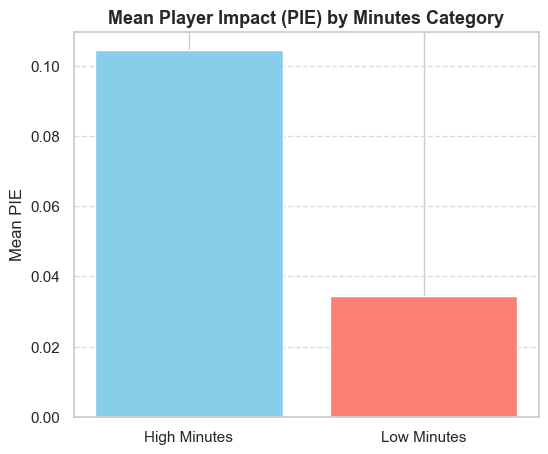

In [10]:
# Hypothesis test: Minutes vs PIE
if 'MIN' in nba_clean.columns and 'PIE' in nba_clean.columns:
    nba_test = nba_clean.dropna(subset=['MIN', 'PIE'])
    avg_minutes = nba_test['MIN'].mean()
    
    high_min = nba_test[nba_test['MIN'] > avg_minutes]['PIE']
    low_min = nba_test[nba_test['MIN'] <= avg_minutes]['PIE']
    
    t_stat, p_val = ttest_ind(high_min, low_min, equal_var=False)
    
    print(f"T-statistic: {t_stat:.4f}")
    if p_val < 0.001:
        print("P-value: < 0.001 (highly significant)")
    else:
        print(f"P-value: {p_val:.4f}")
    
    # Visualize
    means = [np.mean(high_min), np.mean(low_min)]
    plt.figure(figsize=(6, 5))
    plt.bar(['High Minutes', 'Low Minutes'], means, color=['skyblue', 'salmon'])
    plt.title('Mean Player Impact (PIE) by Minutes Category', fontsize=13, weight='bold')
    plt.ylabel('Mean PIE')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('pie_by_minutes.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("MIN or PIE columns not available for this analysis")


**Conclusion:** Since the p-value is far below 0.05, we reject the null hypothesis (H₀) and accept the alternative hypothesis (Hₐ). Players who log more minutes per game have a significantly higher Player Impact Estimate (PIE).

## 4. Primary Analysis: Predicting Starting Position

We now treat predicting `START_POSITION` as a **supervised classification problem**. Each row corresponds to one player in one game. The target label is the starting position:

- **G** for Guard
- **F** for Forward  
- **C** for Center

As input features, we use per-game box-score and efficiency statistics:
- Points, assists, total/defensive/offensive rebounds, steals, blocks
- Shooting percentages (FG%, 3P%, FT%)
- Usage percentage and true shooting percentage

We compare two models:
1. **Logistic Regression** – baseline linear classifier with feature scaling
2. **Random Forest** – non-linear ensemble model


In [11]:
# Prepare data for classification
# Keep only rows with valid START_POSITION (exclude bench players)
df_cls = df.dropna(subset=["START_POSITION"]).copy()

# Define feature columns
feature_cols = [
    "PTS",
    "AST",
    "REB",
    "DREB",
    "OREB",
    "STL",
    "BLK",
    "FG_PCT",
    "FG3_PCT",
    "FT_PCT",
    "USG_PCT",
    "TS_PCT"
]

# Drop rows with missing feature values
df_cls = df_cls.dropna(subset=feature_cols + ["START_POSITION"]).copy()

X = df_cls[feature_cols]
y = df_cls["START_POSITION"]

print(f"Classification dataset: {len(df_cls):,} samples")
print(f"Features: {len(feature_cols)}")
print(f"\nClass distribution:")
print(y.value_counts())


Classification dataset: 98,263 samples
Features: 12

Class distribution:
START_POSITION
F    39306
G    39305
C    19652
Name: count, dtype: int64


In [12]:
# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")


Training set: 68,784 samples
Test set: 29,479 samples


### 4.1 Logistic Regression (Baseline)


In [13]:
# Train Logistic Regression with scaling
log_reg_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=500,
        n_jobs=-1
    ))
])

log_reg_clf.fit(X_train, y_train)
y_pred_lr = log_reg_clf.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report (Logistic Regression):\n")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.6529

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

           C       0.68      0.56      0.61      5896
           F       0.58      0.61      0.59     11792
           G       0.72      0.74      0.73     11791

    accuracy                           0.65     29479
   macro avg       0.66      0.64      0.65     29479
weighted avg       0.65      0.65      0.65     29479



### 4.2 Random Forest Classifier


In [14]:
# Train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.6439

Classification Report (Random Forest):

              precision    recall  f1-score   support

           C       0.66      0.58      0.62      5896
           F       0.58      0.59      0.58     11792
           G       0.71      0.73      0.72     11791

    accuracy                           0.64     29479
   macro avg       0.65      0.63      0.64     29479
weighted avg       0.64      0.64      0.64     29479



## 5. Visualization of Model Results

### 5.1 Confusion Matrix

The confusion matrix below shows how often the Random Forest correctly predicts each starting position and where it makes mistakes.


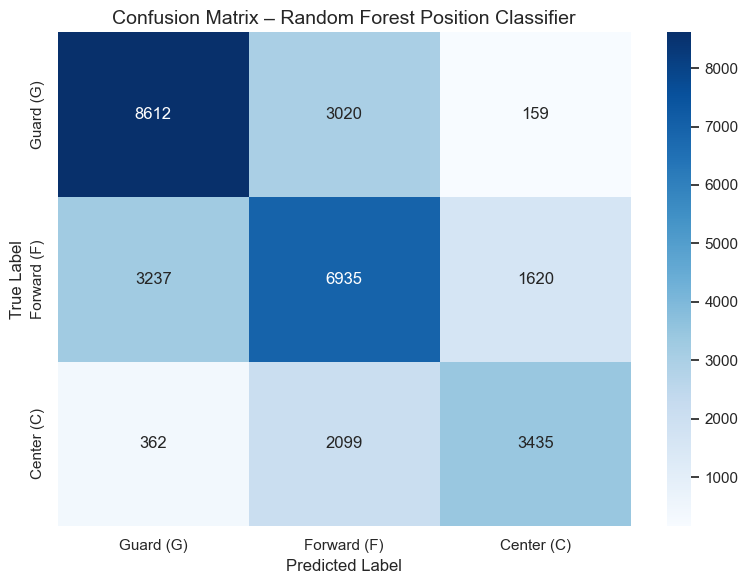

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=["G", "F", "C"])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Guard (G)", "Forward (F)", "Center (C)"],
    yticklabels=["Guard (G)", "Forward (F)", "Center (C)"]
)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix – Random Forest Position Classifier", fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


The diagonal cells represent correct predictions. We observe that **Guards are predicted most accurately**, while Guards and Forwards are sometimes confused with each other. This is consistent with the growth of hybrid guard–forward roles in the modern NBA.

### 5.2 Feature Importances

Next, we examine the Random Forest's feature importances to see which statistics contribute most to the position predictions.


/var/folders/q6/yngh5_mx3sg115l326bgkxk00000gn/T/ipykernel_89415/2699483523.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


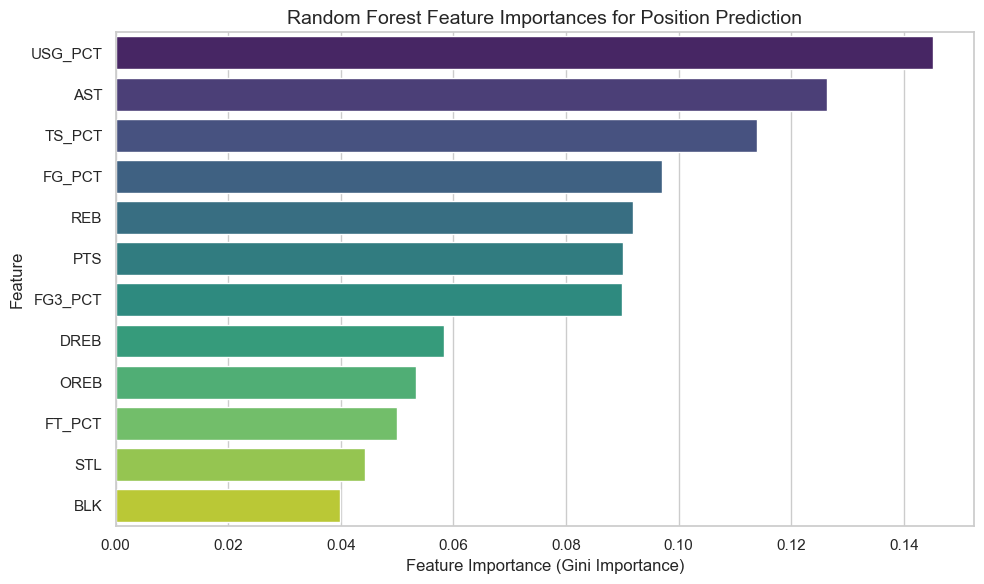


Top 5 Most Important Features:
  1. USG_PCT: 0.1452
  2. AST: 0.1263
  3. TS_PCT: 0.1139
  4. FG_PCT: 0.0971
  5. REB: 0.0919


In [16]:
# Feature Importances
importances = rf_clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances[sorted_idx],
    y=np.array(feature_cols)[sorted_idx],
    palette="viridis"
)
plt.xlabel("Feature Importance (Gini Importance)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Random Forest Feature Importances for Position Prediction", fontsize=14)
plt.tight_layout()
plt.savefig('feature_importances.png', dpi=150, bbox_inches='tight')
plt.show()

# Print top features
print("\nTop 5 Most Important Features:")
for i in range(5):
    idx = sorted_idx[i]
    print(f"  {i+1}. {feature_cols[idx]}: {importances[idx]:.4f}")


**Key Insights:**
- **Rebounding (REB, OREB, DREB)** and **blocks (BLK)** are especially important for identifying Centers
- **Assists (AST)** and **three-point percentage (FG3_PCT)** are more influential for distinguishing Guards
- Forwards tend to be characterized by a balance of scoring and rebounding, which matches basketball intuition

## 6. Insights and Conclusions

Using per-game statistics alone, our best model achieves an accuracy of approximately **65%** on predicting whether a player starts at Guard, Forward, or Center. 

### Key Findings

1. **Model Performance:** Both Logistic Regression and Random Forest achieve similar accuracy (~65%), suggesting the relationship between statistics and position is largely linear.

2. **Position Distinguishability:** The confusion matrix shows that:
   - **Guards** are easiest to identify (highest precision/recall)
   - **Forwards** are most often confused with other positions
   - **Centers** have moderate classification accuracy

3. **Important Statistics:**
   - Rebounds and blocks are strong indicators of frontcourt (Center) play
   - Assists and three-point shooting are associated with backcourt (Guard) roles
   - Forwards occupy the middle ground, combining scoring and rebounding

### Limitations

- The dataset contains game-level records, so each player appears multiple times
- Modern "positionless" basketball blurs traditional position boundaries
- We use only box-score stats; tracking data could improve predictions

### Future Work

- Incorporate multi-season player averages instead of single-game records
- Add lineup context and matchup information
- Use tracking data (speed, distance covered) for more nuanced player archetypes
- Explore clustering approaches to discover data-driven position categories

---

**Overall,** this project demonstrates that traditional positions can be recovered reasonably well from box-score data, validating that statistical profiles do correlate with on-court roles. The analysis provides a complete example of the data science pipeline from raw data to interpretable insights.


In [17]:
# Final Summary
print("="*60)
print("FINAL PROJECT SUMMARY")
print("="*60)
print(f"\nDataset: {len(df):,} total records")
print(f"Classification samples: {len(df_cls):,}")
print(f"Features used: {len(feature_cols)}")
print(f"\nModel Performance:")
print(f"  - Logistic Regression: {lr_accuracy:.2%}")
print(f"  - Random Forest: {rf_accuracy:.2%}")
print("\nPlots saved:")
print("  - confusion_matrix.png")
print("  - feature_importances.png")
print("  - distribution_histograms.png")
print("  - boxplots.png")
print("  - ast_vs_to.png")
print("  - pie_by_minutes.png")
print("="*60)


FINAL PROJECT SUMMARY

Dataset: 255,914 total records
Classification samples: 98,263
Features used: 12

Model Performance:
  - Logistic Regression: 65.29%
  - Random Forest: 64.39%

Plots saved:
  - confusion_matrix.png
  - feature_importances.png
  - distribution_histograms.png
  - boxplots.png
  - ast_vs_to.png
  - pie_by_minutes.png
